In [ ]:
import numpy as np
import pandas as pd
import re
import warnings

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

In [1]:
data = pd.read_csv('../data/data_keep_50000.csv', low_memory=False)
train_df = pd.read_csv('../data/meinian_round1_train_20180408.csv')
test_df = pd.read_csv('../data/meinian_round1_test_a_20180409.csv')

# 通过 describe 查看特征的类型，标准差，修正类型和异常数据
train_df['收缩压'] = pd.to_numeric(train_df['收缩压'], errors='coerce')
train_df['舒张压'] = pd.to_numeric(train_df['舒张压'], errors='coerce')
train_df.loc[22712, '血清甘油三酯'] = 7.75
train_df['血清甘油三酯'] = pd.to_numeric(train_df['血清甘油三酯'], errors='coerce')
# train_df['舒张压'].sort_values(ascending=False)[:5]
train_df.loc[22357, '舒张压'] = np.nan
train_df.loc[29394, '舒张压'] = np.nan
train_df.loc[29394, '收缩压'] = np.nan
train_df['血清低密度脂蛋白'][train_df['血清低密度脂蛋白']<0] = 0

In [2]:
# 合并数据
merged_train_df = pd.merge(train_df, data, on='vid', sort=False)
merged_test_df = pd.merge(test_df, data, on='vid', sort=False)
combine = [merged_train_df, merged_test_df]

In [3]:
print(merged_train_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38199 entries, 0 to 38198
Columns: 262 entries, vid to A601
dtypes: float64(16), object(246)
memory usage: 76.6+ MB
None


In [4]:
# 提取数值特征(大于0.5)
numerical_feature = []

def get_num_prop(data_col):
    num_counts = data_col.astype(
        str).str.match(r'^(-?\d+)(\.\d+)?$').sum()
    na_counts = data_col.isna().sum()
    return num_counts / (data_col.shape[0] - na_counts)

for col in merged_train_df.columns.values:
    if get_num_prop(merged_train_df[col]) > 0.5:
        numerical_feature.append(col)

label = numerical_feature[0:5]        
numerical_feature = numerical_feature[5:]
print('numerical feature count: %s' %len(numerical_feature))
print(numerical_feature)

numerical feature count: 108
['0424', '100005', '100006', '100007', '100014', '10002', '10003', '10004', '1106', '1107', '1115', '1117', '1127', '1321', '1322', '1325', '1326', '1345', '139', '143', '1474', '155', '1814', '1815', '183', '1840', '1845', '1850', '190', '191', '192', '193', '2174', '2333', '2372', '2403', '2404', '2405', '2406', '2420', '269003', '269004', '269005', '269006', '269007', '269008', '269009', '269010', '269011', '269012', '269013', '269014', '269015', '269016', '269017', '269018', '269019', '269020', '269021', '269022', '269023', '269024', '269025', '300017', '300021', '31', '312', '313', '314', '315', '316', '317', '319', '3193', '32', '320', '33', '34', '37', '38', '39', '669001', '669002', '669006', '809001', '809009', '979001', '979002', '979003', '979004', '979005', '979006', '979007', '979008', '979009', '979011', '979012', '979013', '979014', '979015', '979016', '979017', '979018', '979019', '979020', '979021', '979022', '979023']


In [5]:
def search_non_numeric(data):
    if not re.search(r'^(-?\d+)(\.\d+)?$', data) and data!='nan':
        non_numeric.append(data)

# non_numeric = []
# # applymap 会有问题，第一列会操作两次
# for col in numerical_feature:
#     non_numeric.append('----'+col+'----')
#     temp = merged_train_df[col].astype('str').apply(search_non_numeric)
# for col in numerical_feature:
#     non_numeric.append('----'+col+'----')
#     temp = merged_test_df[col].astype('str').apply(search_non_numeric)

In [6]:
# len(non_numeric)

In [7]:
# with open('mix_in_numeric.txt', 'w') as f:
#     for t in non_numeric:
#         f.write(t+'\n')

In [8]:
def print_non_num(feature_series):
    print(feature_series[feature_series.str.match(r'^(-?\d+)(\.\d+)?$')==False])

In [9]:
def convert_mixed_num(data):
    data = data.strip()
    special_cases = ['未见','阴性']
    try:
        ret = float(data)
        return ret if data >=0 else np.nan
    except:
        if data in special_cases:
            return 0
        all_match = re.findall(r'\d+\.?\d*', data) # 注意：不带负号
        if all_match:
            all_list = [float(i) for i in all_match]
            return sum(all_list)/len(all_list)    # 取均值
        else:
            return np.nan

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

test = merged_train_df['269023'].astype(
        'str').apply(convert_mixed_num).dropna()
sns.distplot(test)
plt.show()

In [11]:
merged_train_df.loc[32230,'1850'] = 3.89
merged_train_df.loc[[2527,3027],'192'] = 16.07, 12.01
merged_train_df.loc[3163,'193'] = np.nan
merged_train_df.loc[6055,'2333'] = 5.0    # 多了小数点
merged_train_df.loc[5085,'269013']    # 未见，映射成0
merged_train_df.loc[[8551,8840,9072,9309],'3193'] = '>=1.030'
merged_test_df.loc[2327, '3193'] = '>=1.030'
merged_test_df.loc[2327, '1840'] = '<=5.0'

In [12]:
merged_train_df.loc[21196,'2405'] = np.nan  # 异常大
merged_train_df.loc[33729,'0424'] = np.nan
merged_train_df.loc[21196,'2403'] = np.nan

In [13]:
# RF 得到的特征重要性
low_importance = ['269024', '979013', '979018', '1325', '979014', '1326']

for df in combine:
    df[numerical_feature] = df[numerical_feature].astype(
    'str').applymap(convert_mixed_num)
    # to_fill = df[numerical_feature].median()
    # df[numerical_feature] = preprocessing.robust_scale(df[numerical_feature].fillna(to_fill))
    df.drop(columns=low_importance, inplace=True)    # 去掉不重要的特征

need_log1p = ['100007', '1117', '1127', '1814', '1815', '183']
for col in need_log1p:
    for df in combine:
        df[col] = np.log1p(df[col])

In [14]:
numerical_feature = [i for i in numerical_feature if i not in low_importance]

In [15]:
label_numerical_df = merged_train_df[label + numerical_feature]

In [16]:
# corr = label_numerical_df.corr()
# sns.pairplot(corr)

In [17]:
# plt.show()

In [80]:
merged_test_df.describe()

,收缩压,舒张压,血清甘油三酯,血清高密度脂蛋白,血清低密度脂蛋白,0424,100005,100006,100007,100014,10002,10003,10004,1106,1107,1115,1117,1127,1321,1322,1345,139,143,1474,155,1814,1815,183,1840,1845,1850,190,191,192,193,2174,2333,2372,2403,2404,2405,2406,2420,269003,269004,269005,269006,269007,269008,269009,269010,269011,269012,269013,269014,269015,269016,269017,269018,269019,269020,269021,269022,269023,269025,300017,300021,31,312,313,314,315,316,317,319,3193,32,320,33,34,37,38,39,669001,669002,669006,809001,809009,979001,979002,979003,979004,979005,979006,979007,979008,979009,979011,979012,979015,979016,979017,979019,979020,979021,979022,979023
count,0.0,0.0,0.0,0.0,0.0,7532.000000,3249.000000,4372.000000,3763.000000,1217.000000,5042.000000,4583.000000,8657.000000,1391.000000,1355.000000,5740.000000,6519.000000,1985.000000,4300.000000,4303.000000,2258.000000,1455.000000,1292.000000,1314.000000,2186.000000,9473.000000,9006.000000,5140.000000,9155.000000,4268.000000,8740.000000,9350.000000,9255.000000,7441.000000,6428.000000,5014.000000,4383.000000,4327.000000,9167.000000,9167.000000,9122.000000,3362.000000,2486.000000,2016.000000,2047.000000,1980.000000,2016.000000,1775.000000,2016.000000,2016.000000,2016.000000,1975.000000,2016.000000,2024.000000,2014.000000,2045.000000,2014.000000,2016.000000,2047.000000,2016.000000,2047.000000,2047.000000,2047.000000,2047.000000,2037.000000,1271.000000,1454.000000,4434.000000,4403.000000,4371.000000,5508.000000,4434.000000,4434.000000,4371.000000,4434.000000,9144.000000,4394.000000,4267.000000,4363.000000,3528.000000,4434.000000,4434.000000,3559.000000,1269.000000,1289.000000,1230.000000,1450.000000,1257.000000,1738.000000,1694.000000,1745.000000,1746.000000,1580.000000,1670.000000,1746.000000,1746.000000,1746.000000,1746.000000,1751.000000,1746.000000,1746.00000,1746.000000,1711.000000,1746.000000,1746.000000,1746.000000,1746.000000
mean,NaN,NaN,NaN,NaN,NaN,72.824615,19.044075,14.465755,0.233370,15.539181,9.180084,28.575555,4.850887,1.459418,0.971849,75.299970,3.292013,4.606939,0.818479,0.833377,173.668446,1.603109,13.950039,93.501763,2.335300,3.203359,3.140649,4.332002,6.103222,1.669923,5.272363,70.642619,334.526421,13.244318,4.036686,46.646350,1.716191,3.249052,66.657241,165.031068,24.347961,58.012061,78.070314,15.253720,9.242013,0.193128,212.932044,46.146085,340.847222,30.804812,90.268353,42.340565,146.614087,4.752576,3.702415,0.394585,1.812570,60.182589,6.520435,30.334812,6.093307,2.711466,0.231568,0.166135,13.347914,1.115247,9.938844,4.739432,6.275523,142.969851,39.095807,90.537900,30.242402,334.134546,214.913848,1.018755,3.783976,9.417546,2.078981,0.427678,57.471347,30.652443,7.576245,3.586543,1.506105,7.744958,6.301769,1.598640,15.372463,0.190894,9.261026,213.033677,12.132215,39.589533,325.337514,30.244341,91.708288,142.084880,4.763210,3.509483,0.35305,2.054227,2.464816,56.969966,5.834828,34.238270,6.097045
std,NaN,NaN,NaN,NaN,NaN,9.140353,12.156971,2.661384,0.378775,6.388104,4.156073,4.207401,1.301784,0.266599,0.261489,23.885392,0.656234,0.454902,0.381827,0.376201,33.633483,0.514700,8.370942,31.710993,3.249644,0.548896,0.320066,0.063319,0.680201,0.292587,1.316829,20.439175,94.950076,5.477686,2.027412,3.212245,1.425697,3.316752,12.766065,8.875389,3.539728,7.777816,11.136415,3.364548,1.485286,0.051775,54.719223,4.678848,15.683136,2.495205,5.961137,7.028090,16.941759,0.595598,1.212102,0.149875,0.586123,8.728309,1.976968,8.167379,1.540953,2.205780,0.298584,0.166724,1.686410,1.394992,8.319740,0.515019,1.610241,16.413521,13.003319,6.003174,2.464576,14.952880,55.968985,0.043075,1.250886,1.791144,0.733974,0.203998,13.934575,10.821147,6.206759,2.795492,1.134165,8.322365,3.755914,0.740983,2.341082,0.047911,1.512181,58.497532,1.084198,9.361523,40.287501,2.412808,6.568473,23.413885,0.579706,1.173386,0.12099,0.599238,2.042286,8.059107,1.501949,7.509697,1.556471
min,NaN,NaN,NaN,NaN,NaN,42.000000,0.000000,7.700000,0.041142,0.360000,0.270000,15.570000,1.590000,0.600000,0.000000,22.630000,1.791759,2.644755,0.010000,0.010000,42.000

In [79]:
merged_train_df['2403'].dropna().sort_values().tail()

25556      147.6
27379      150.1
31084      151.1
24805      154.0
21196    57142.0
Name: 2403, dtype: float64

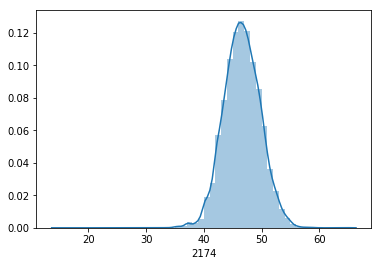

In [20]:
# test = merged_train_df['100007'].dropna()
test = merged_train_df['2174']
sns.distplot(test.dropna())
plt.show()

In [21]:
# %matplotlib inline
# fig = plt.gcf()
# fig.set_size_inches(18, 18)
# sns.heatmap(merged_train_df[label+numerical_feature].corr())
# plt.show()

In [22]:
merged_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38199 entries, 0 to 38198
Columns: 256 entries, vid to A601
dtypes: float64(107), object(149)
memory usage: 76.1+ MB


In [77]:
merged_train_df[numerical_feature].describe()

,0424,100005,100006,100007,100014,10002,10003,10004,1106,1107,1115,1117,1127,1321,1322,1345,139,143,1474,155,1814,1815,183,1840,1845,1850,190,191,192,193,2174,2333,2372,2403,2404,2405,2406,2420,269003,269004,269005,269006,269007,269008,269009,269010,269011,269012,269013,269014,269015,269016,269017,269018,269019,269020,269021,269022,269023,269025,300017,300021,31,312,313,314,315,316,317,319,3193,32,320,33,34,37,38,39,669001,669002,669006,809001,809009,979001,979002,979003,979004,979005,979006,979007,979008,979009,979011,979012,979015,979016,979017,979019,979020,979021,979022,979023
count,30269.000000,12899.000000,17473.000000,15043.000000,4938.000000,20113.000000,18408.000000,34717.000000,5705.000000,5568.000000,22979.000000,26085.000000,8222.000000,17015.000000,17009.000000,9234.000000,5666.000000,5427.000000,5080.000000,8820.000000,38018.000000,36194.000000,20705.000000,36665.000000,17145.000000,35078.000000,37461.000000,37082.000000,29808.000000,25799.000000,20210.000000,17493.000000,17349.000000,36776.000000,36777.000000,36608.000000,13217.000000,9775.000000,8218.000000,8362.000000,8058.000000,8219.000000,7288.000000,8219.000000,8219.000000,8219.000000,7980.000000,8219.000000,8249.000000,8215.000000,8359.000000,8215.000000,8219.000000,8363.000000,8219.000000,8363.00000,8362.000000,8362.000000,8362.000000,8316.000000,5058.000000,5829.000000,17712.000000,17571.000000,17459.000000,22234.000000,17712.000000,17712.000000,17459.000000,17712.000000,36638.000000,17553.000000,16938.000000,17409.000000,13957.000000,17712.000000,17712.000000,14101.000000,5289.000000,5367.000000,5160.000000,5649.000000,4858.000000,6832.000000,6704.000000,6869.000000,6870.000000,6286.000000,6615.000000,6870.000000,6870.000000,6870.000000,6870.000000,6905.000000,6870.000000,6871.000000,6870.000000,6766.000000,6870.000000,6871.000000,6870.000000,6870.000000
mean,72.890515,18.969464,14.448569,0.236468,15.415094,9.183797,28.616702,4.891171,1.450423,0.957126,75.152059,3.289471,4.610347,0.817170,0.826037,173.631159,1.592666,13.674605,93.227131,2.272346,3.210058,3.142526,4.332010,6.114276,1.664133,5.278316,70.512614,333.618480,13.249230,4.064471,46.600614,1.724999,3.318521,68.275377,165.120286,24.342537,58.090440,78.198271,15.227035,9.235608,0.196681,214.206473,46.271937,340.019601,30.710196,90.245711,42.113750,145.770288,4.739366,3.714734,0.397310,1.802418,60.325677,6.579583,30.182888,6.09749,2.694310,0.233265,0.165098,13.340669,1.100812,10.139740,4.736107,6.257604,143.232866,38.991491,90.603513,30.289683,334.513494,215.117475,1.019033,3.768755,9.410126,2.076115,0.426795,57.697587,30.840653,7.730919,3.513815,1.484888,7.259435,6.435024,1.620080,15.403295,0.192409,9.230496,214.194367,12.153151,39.875247,325.288295,30.151803,91.503314,142.016303,4.766898,3.520148,0.354890,2.060746,2.497774,56.981725,5.831713,34.172217,6.120060
std,9.074867,12.073726,2.659313,0.394287,5.406276,4.083286,4.205664,9.717190,0.260296,0.247000,24.124697,0.667826,0.499099,0.375756,0.374986,32.366895,0.541051,7.735491,31.729177,2.853174,0.551059,0.324532,0.063578,0.693084,0.289807,1.335770,18.377908,94.177682,5.520909,2.299311,3.148518,2.616296,5.314787,297.903978,8.684456,3.579534,7.642405,11.335366,3.243515,1.476703,0.130491,55.690242,4.622187,15.234826,2.594303,6.180244,7.322649,17.252298,0.585971,1.277855,0.149939,0.610732,8.814129,1.976209,8.304851,1.61659,2.199148,0.334817,0.161030,1.652563,1.385793,8.359404,0.523044,1.620847,16.772720,13.188444,6.050279,2.471872,15.049161,55.691769,0.039605,1.258986,1.791910,0.737653,0.209125,13.335674,10.749796,6.360497,3.364076,1.251068,6.600688,3.904337,0.803286,2.341114,0.061081,1.516073,60.025304,1.100930,9.050131,39.996788,2.495340,6.630818,23.334301,0.627020,1.175713,0.128518,0.603731,2.095885,7.925545,1.565962,7.411013,1.570829
min,40.000000,4.000000,0.000000,0.000000,0.420000,0.140000,7.200000,1.190000,0.680000,0.030000,1.800000,0.000000,2.772589,0.010000,0.010000,81.000000,0.000000,0.600000,0.000000,0.000000,0.693147,0.262364,3.160399,4.

In [24]:
# abnormal_num = []
# for col in numerical_feature:
#     if merged_train_df[col].max() > 1000:
#         abnormal_num.append(col)
# print(abnormal_num)

In [25]:
merged_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38199 entries, 0 to 38198
Columns: 256 entries, vid to A601
dtypes: float64(107), object(149)
memory usage: 76.1+ MB


In [26]:
merged_train_df.describe(include='O')

,vid,0101,0102,0113,0114,0115,0116,0117,0118,0119,0120,0121,0122,0123,0124,0201,0202,0203,0206,0207,0208,0209,0210,0212,0215,0216,0217,0222,0225,0403,0405,0406,0407,0409,0413,0414,0420,0421,0422,0423,0425,0426,0427,0428,0429,0430,0431,0432,0433,0434,0435,0436,0440,0501,0503,0509,0516,0537,0539,0541,0702,0703,0705,0706,0707,0709,0715,0726,0728,0730,0731,0901,0911,0912,0929,0947,0949,0954,0972,0973,0974,0975,0976,0977,0978,0979,0980,0981,0982,0983,0984,0985,0987,100010,1001,1102,1103,1104,1301,1302,1303,1304,1305,1308,1313,1314,1315,1316,1328,1329,1330,1402,2228,2229,2230,2231,2233,2302,2501,300005,300018,300019,300036,30007,3189,3190,3191,3192,3194,3195,3196,3197,3207,3301,3399,3400,3429,3430,3485,3486,360,3601,3730,4001,A201,A202,A301,A302,A601
count,38199,32509,37643,37311,37304,33977,37222,36589,36588,20904,18877,12978,12978,12978,14132,21674,21959,21932,18884,21011,21200,20113,20842,20770,20150,20532,21953,21979,7610,13885,24659,25308,27517,32056,29071,5411,30568,31728,9400,27036,17950,31868,8956,5785,13799,30515,30261,25883,25802,31518,26710,6751,7495,12378,12379,12370,12138,12074,12380,12074,14983,14978,14939,14980,15023,15112,14179,13935,12819,14173,14645,26755,28425,28173,26075,28417,28388,28438,14210,19971,25104,25047,24901,15755,23770,22850,21706,7294,7229,7440,7161,25157,5446,27116,37092,17772,16973,2062,24637,24458,22627,23016,20911,26625,18736,19009,19851,14903,16814,11392,5841,7716,11209,10712,10603,10603,10580,37483,10529,34183,5592,5773,11443,10608,9978,36549,36669,36669,8388,36669,36596,36669,24729,8751,23264,22797,33527,36669,10458,10795,7889,14794,33489,8426,22690,22817,5028,5052,9180
unique,38199,19667,31701,6031,4216,100,464,3362,3064,229,5571,5613,584,624,51,63,79,190,11,18,90,180,93,11,157,27,111,2979,169,9,40,23,14,2503,102,3,14,63,4,34,28,93,9,3,15,8,9,7,8,1916,66,52,20,80,580,1626,459,63,5403,66,312,789,205,131,37,5547,116,21,4,244,845,45,101,236,272,121,179,5076,125,26,41,151,10,3,871,4,3,10,5,46,31,97,248,31,2969,2413,4858,113,128,323,38,14,65,8633,27,216,30,407,31,115,548,936,112,174,74,194,208,30,916,258,635,484,1548,28,16,19,13,16,12,17,21,5,21,1856,10,10,298,24,24,17,18,410,34,165,7452,4597,1924,1114,66
top,9ef119d71b14fbef321f8cc252ab1f87,双侧甲状腺大小形态正常，包膜光整，实质回声均匀，未见明显异常回声。CDFI：血流显示未见异常。,肝、胆、胰、脾、左肾、右肾未发现明显异常,肝脏大小、形态正常，包膜光整，肝内血管走行较清晰，回声均匀。,胆囊大小、形态正常，囊壁光整，囊腔内透声好，胆总管无扩张。,胰腺大小、形态正常，边缘规整，内部回声均匀，胰管未见扩张。,脾脏大小、形态正常，包膜光整，回声均匀。,左肾大小、形态正常，包膜光滑，肾实质回声均匀，集合系统未见明显分离。,右肾大小、形态正常，包膜光滑，肾实质回声均匀，集合系统未见明显分离。,膀胱充盈良好，壁光滑，延续性好，其内透声性良好，未见明显占位性病变。,前列腺大小、形态正常，包膜光滑完整，两侧对称，内部回声均匀。,子宫大小形态正常，宫壁回声均匀，内膜线居中。,左附件区未见明显异常回声。,右附件区未见明显异常回声。,输尿管上段、膀胱壁间段无扩张。,正常,正常,正常,正常,正常,正常,正常,正常,无,正常,正常,正常,耳鼻喉检查未见异常,未见异常,未见异常,未见异常,未见异常,未见异常,内科检查未发现明显异常,未见异常,未见异常,未见异常,整齐,未见异常,未见异常,正常,未见异常,未见异常,未见异常,未见异常,未见异常,未见异常,未见异常,未见异常,无,未见异常,无,未见异常,未见异常,通畅、分泌物少,光滑、大小正常,前位、大小正常、质软,未见异常,妇科检查未发现明显异常,未见异常,无,无,未见明显异常,未见明显异常,未见明显异常,口腔检查未发现明显异常,无,未见明显异常,未见明显异常,无,未见明显异常,未见异常,未见异常,未见异常,未见异常,未见异常，活动自如,未见异常，活动自如,外科检查未发现明显异常,未见异常,无,无,无,无,无,无,无,无,未见异常,未见异常,未见异常,未见异常,无,无,-,正常心电图,心、肺、膈未见明显异常,两侧胸廓对称，气管居中，两肺野显示清晰。两肺门未见增大，主动脉弓及心影大小形态未见异常，两横...,nan;nan,正常,正常,正常,正常,正常,眼科检查（含裂隙灯）未发现明显异常,正常,正常,正常,正常,正常,无,眼底检查未发现明显异常,所检颅内动脉血流速度未见明显异常,阴性,阴性,阴性,阴性,阴性,健康,未见上皮内病变或恶性细胞,未见,阴性,阴性,-,Ⅱ,-,-,-,-,-,-,-,-,未见,HP阴性(dpm=0),黄色,透明,未见,-,阴性,阴性,-,骨量正常,未见,血管弹性度正常，血管腔未见狭窄,胸廓对称，双肺纹理清晰，走行自然，未见异常实变影，双肺门不大。纵隔窗示纵隔无偏移，心影及大血...,详见纸质报告,双侧大脑半球对称，大脑灰白质形态、位置、信号未见异常。脑干、小脑实质未见明显异常信号，FLA...,详见纸质报告,详见纸质报告
freq,1,2859,196,7224,20584,23397,15268,21482,21605,16066,6694,3048,8500,8588,13375,14250,14481,14159,10281,13049,12597,11567,12468,16295,7701,12748,14251,5600,2872,9625,23184,19894,22548,14926,27386,3255,23395,29395,6892,22784,10742,24755,6917,5570,12753,27558,23318,20909,20035,19002,24527,4363,6041,10679,5602,2505,1947,9803,1406,9734,12503,10422,7504,12113,13561,1613,13572,13405,11296,12230,10723,25167,25641,23827,20086,24933,25260,7055,4290,18663,24932,21920,24875,15753,19943,22847,21704,5424,5631,5703,3820,20227,4612,23651,8787,1210,2870,1671,14113,13010,13843,13613,10703,689,10390,9267,10263,7432,11649,3493,1543,930,924

In [27]:
# 这行开始
merged_train_df.to_pickle('../data/data_train_num.pkl')
merged_test_df.to_pickle('../data/data_test_num.pkl')

In [29]:
non_numerical_feature = merged_train_df.describe(include='O').columns.values[1:]
len(non_numerical_feature)

In [31]:
non_numerical_df = merged_train_df[non_numerical_feature]
non_numerical_desc = non_numerical_df.describe()

In [32]:
unique_less_than_100 = non_numerical_desc.iloc[1,:][non_numerical_desc.iloc[1,:] < 100].index.values

In [33]:
len(unique_less_than_100)

75

In [34]:
unique_less_than_100

array(['0124', '0201', '0202', '0206', '0207', '0208', '0210', '0212',
       '0216', '0403', '0405', '0406', '0407', '0414', '0420', '0421',
       '0422', '0423', '0425', '0426', '0427', '0428', '0429', '0430',
       '0431', '0432', '0433', '0435', '0436', '0440', '0501', '0537',
       '0541', '0707', '0726', '0728', '0901', '0973', '0974', '0976',
       '0977', '0979', '0980', '0981', '0982', '0983', '0984', '0985',
       '100010', '1303', '1304', '1305', '1313', '1315', '1328', '2230',
       '2302', '30007', '3189', '3190', '3191', '3192', '3194', '3195',
       '3196', '3197', '3207', '3399', '3400', '3430', '3485', '3486',
       '360', '3730', 'A601'], dtype=object)

In [166]:
# 方便实验，重新载入
merged_train_df = pd.read_pickle('../data/data_train_num.pkl')
merged_test_df = pd.read_pickle('../data/data_test_num.pkl')
combine = [merged_train_df, merged_test_df]

In [167]:
# 去掉前后空白
for col in non_numerical_feature:
    merged_train_df.loc[:, col] = merged_train_df.loc[:, col].str.strip()
    merged_test_df.loc[:, col] = merged_test_df.loc[:, col].str.strip()
# sns.countplot(y='0124', data=merged_train_df, palette="Greens_d");·`

In [38]:
def converter(pat):
    def convert(data):
        if data == data:
            if re.search(pat, data):
                return 0
            else:
                return 1
        return data
    return convert

In [40]:
# 测试转换之后结果
for df in combine:
    df['0405'] = df['0405'].apply(converter(r'(无|未)')).astype('category')

In [41]:
for df in combine:
    df['0406'] = df['0406'].apply(converter(r'(未|正常)')).astype('category')

In [42]:
for df in combine:
    df['0407'] = df['0407'].apply(converter(r'(未|弃)')).astype('category')

In [54]:
for df in combine:    
    df['0420'] = df['0420'].apply(converter(r'(未|正常)')).astype('category')

In [214]:
def convert_0421(data):
    if data == data:
        normal = ['整齐','齐','正常','整','整齐;整齐','齐;齐','未见异常']
        if data in normal:
            return 0
        elif re.search(r'早搏',data):
            return 1
        elif re.search(r'(不齐|过|窦性)',data):
            return 2
        elif re.search(r'房颤',data):
            return 3
        elif re.search(r'齐',data):
            return 0
    return np.nan
for df in combine:    
    df['0421'] = df['0421'].apply(convert_0421).astype('category')

In [59]:
pd.set_option('display.max_rows', 100)

In [215]:
merged_test_df['0421'].value_counts()

0.0    7673
2.0     168
1.0      64
3.0       2
Name: 0421, dtype: int64

In [216]:
merged_train_df['0421'].value_counts()

0.0    30824
2.0      641
1.0      250
3.0       10
Name: 0421, dtype: int64

In [210]:
merged_train_df.groupby('0974').mean().iloc[:,0:5].sort_values(by='收缩压',ascending=False)

,收缩压,舒张压,血清甘油三酯,血清高密度脂蛋白,血清低密度脂蛋白
0974,,,,,
皮肤斑丘疹（全身瘙痒）,169.000000,109.000000,1.330000,1.280000,2.820000
头癣,168.000000,68.000000,2.140000,1.160000,3.870000
化脓性皮肤病,161.000000,74.000000,1.500000,1.540000,3.060000
四肢皮肤淀粉样变,160.000000,80.000000,1.880000,1.400000,2.130000
扁平疣？（胸部）,153.000000,81.000000,1.900000,1.620000,4.230000
"双侧皮疹(双侧大小腿见片状皮疹,嘱皮肤科门诊。）",152.000000,100.000000,7.250000,0.840000,1.250000
yi无,150.000000,96.000000,0.770000,1.390000,2.580000
银屑病（腹部）,148.000000,84.000000,2.010000,1.690000,2.640000
足癣,134.666667,84.611111,2.150000,1.548889,2.977222


In [47]:
merged_train_df.describe(include='category')

,0405,0406,0407,0420
count,24659.0,25308.0,27517.0,30568.0
unique,2.0,2.0,2.0,2.0
top,0.0,0.0,0.0,0.0
freq,24627.0,25269.0,27492.0,23714.0


In [48]:
merged_train_df['0405'].value_counts().index[0]

0.0

In [49]:
cate_feature = merged_train_df.describe(include='category').columns.values.tolist()
most_cate = {}
for col in cate_feature:
    most_cate[col] = merged_train_df[col].value_counts().index[0]

In [50]:
most_cate

{'0405': 0.0, '0406': 0.0, '0407': 0.0, '0420': 0.0}